In [5]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load CelebA

In [38]:
def load_celeba_df(images_dir, attr_path, as_bool=True, verify_files=True):
    """
    images_dir: directory containing the aligned images (e.g. .../img_align_celeba)
    attr_path:  path to list_attr_celeba.txt
    as_bool:    convert attributes from {-1,1} to {False, True}
    verify_files: drop rows whose image file is missing on disk
    """
    with open(attr_path, "r") as f:
        #_num_images = f.readline().strip()         # e.g., "202599" (not used)
        header_line = f.readline().strip()         # 40 attribute names (space-separated)

    attr_names = header_line.split()
    cols = ["image_id"] + attr_names

    df = pd.read_csv(
        attr_path,
        delim_whitespace=True,     # handles variable spacing
        skiprows=1,                # skip num-images and header line
        names=cols,
        engine="python",
    )

    if as_bool:
        df[attr_names] = (df[attr_names] == 1)     # {-1,1} -> {False,True}
    else:
        df[attr_names] = df[attr_names].astype("int8")

    df["image_path"] = df["image_id"].apply(lambda x: os.path.join(images_dir, x))

    return df

images_dir = "/users/aparasel/scratch/temp_data/img_align_celeba"
attr_path  = "/users/aparasel/scratch/temp_data/list_attr_celeba.txt"

celeba_df = load_celeba_df(images_dir, attr_path, as_bool=True, verify_files=True)
print(celeba_df.shape)
print(celeba_df.head())


(202599, 42)
     image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg             False             True        True            False   
1  000002.jpg             False            False       False             True   
2  000003.jpg             False            False       False            False   
3  000004.jpg             False            False        True            False   
4  000005.jpg             False             True        True            False   

    Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Smiling  Straight_Hair  \
0  False  False     False     False       False  ...     True           True   
1  False  False     False      True       False  ...     True          False   
2  False  False      True     False       False  ...    False          False   
3  False  False     False     False       False  ...    False           True   
4  False  False      True     False       False  ...    False          False   

   Wavy_Hair  Weari

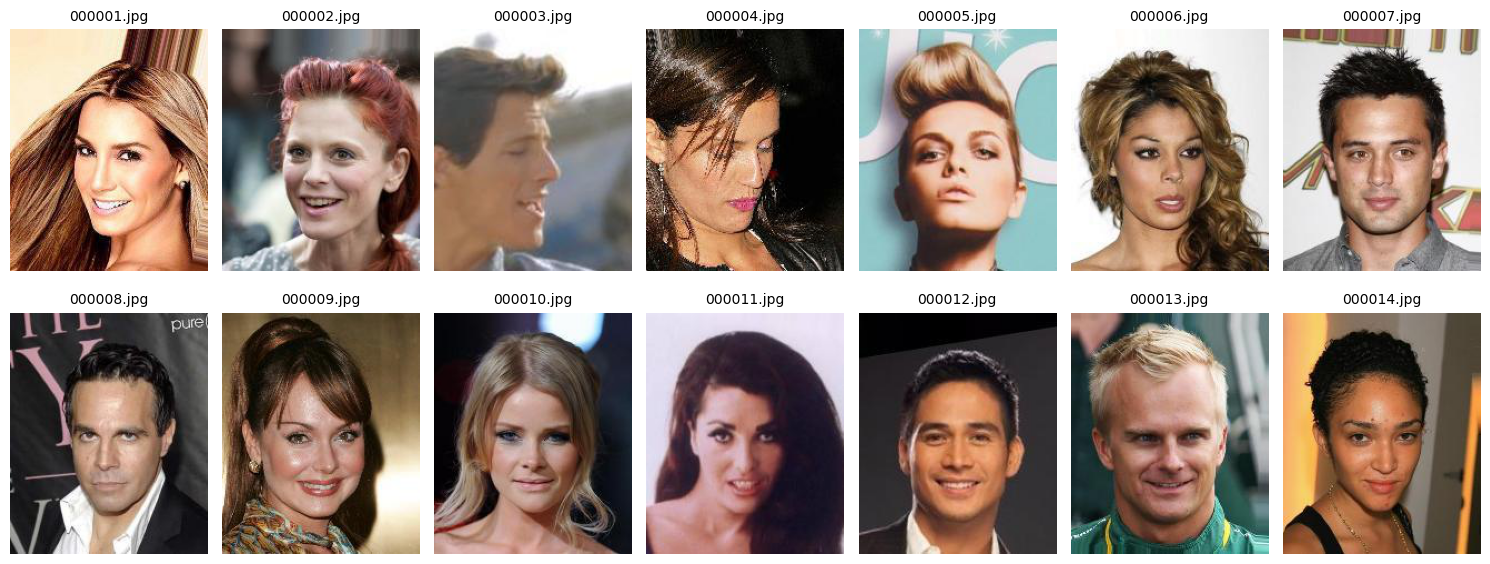

In [57]:

temp = celeba_df[:14]  

fig, axes = plt.subplots(2, 7, figsize=(15, 6)) 
axes = axes.flatten()  

for i, ax in enumerate(axes):
    row = temp.iloc[i]
    img = Image.open(row["image_path"])
    ax.imshow(img)
    ax.set_title(f"{row['image_id']}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


# Utility functions

In [40]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer

model_name = "intfloat/e5-large-v2"  
embd_model = SentenceTransformer(model_name, device="cuda")
def mean_sq_dist_to_centroid(sentence_embs): #Compute average distance from centorid 
    sentence_embs = np.asarray(sentence_embs, dtype=float)

    centroid = sentence_embs.mean(axis=0, keepdims=True)      
    sq_dists = np.sum((sentence_embs - centroid) ** 2, axis=1)
    return float(np.mean(sq_dists))


def sim_to_sentence(selfie_results, correct_sentences):
    correct_embds = embd_model.encode(correct_sentences, batch_size=64, convert_to_numpy=True, normalize_embeddings=True)
    print(correct_embds.shape)
    person_dict = {}
    for person in selfie_results['image_id'].unique():
        print(f"Person is {person}")
        token_dict = {}
        curr_embd = correct_embds[int(person[:-4])-1]
        for token in selfie_results['position_source'].unique():
            layer_outputs = selfie_results[(selfie_results['image_id'] == person) & (selfie_results['position_source'] == token)].iloc[0,6:].to_list()
            layer_embds = embd_model.encode(layer_outputs, batch_size=64, convert_to_numpy=True, normalize_embeddings=True)
            layerwise_sim = layer_embds @ curr_embd
            token_dict[token] = layerwise_sim
        person_dict[person] = token_dict
    return person_dict

def display_results(df, image_id=None, token=None,layer=None,k=3):
    person_df = df
    if image_id is not None:
        print(f"Looking at image {image_id}")
        person_df = df[df['image_id'] == image_id]
    if token is not None:
        print(f"Looking at token {token}")
        person_df = person_df.set_index('token_from_source')
        person_df = person_df.loc[token]
    if layer is not None:
        print(f"Looking at layer {layer}")
        if image_id is None:
            person_df = person_df.set_index('image_id')
            person_df = person_df[f"inspect_layer{layer}"]
            for idx, sentence in person_df.items():
                print(f"{idx}: {sentence}")
        elif (image_id is not None) and (token is not None):
            person_df = person_df[f"inspect_layer{layer}"]
            print(person_df)
        else: 
            person_df = person_df[f"inspect_layer{layer}"]
            for i in person_df:
                print(i)
    else:
        for col, val in person_df.items():
                    print(f"{col}: {val}")
    return person_df

def top_k_token_layer(d, tok_map=None, k=3):
    """
    d: dict {position_source -> list of similarities per layer}
    tok_map: optional dict {position_source -> token string} for nicer labels
    k: how many top pairs to return
    """
    keys = list(d.keys())
    Z = np.vstack([np.asarray(d[k_], dtype=float) for k_ in keys])  # shape (num_tokens, num_layers)

    # Handle NaNs by mapping them to -inf so they won't appear in top-k
    Z_safe = np.where(np.isnan(Z), -np.inf, Z)

    # Get top-k flat indices
    flat = Z_safe.ravel()
    k = min(k, flat.size)
    top_idx = np.argpartition(flat, -k)[-k:]
    top_idx = top_idx[np.argsort(flat[top_idx])[::-1]]  # sort descending

    rows, cols = np.unravel_index(top_idx, Z_safe.shape)

    results = []
    for r, c in zip(rows, cols):
        pos = keys[r]
        label = tok_map.get(pos, str(pos)) if tok_map else str(pos)
        score = float(Z[r, c])
        results.append({
            "position_source": pos,
            "token_label": label,
            "layer": int(c),
            "score": score,
        })
    return results

def plot_dict_heatmap(d,tok_map=None,df=None,show_image=False,image_id=None,k=3):
    if show_image:
        row = celeba_df.loc[celeba_df["image_id"] == image_id]
        if row.empty:
            print(f"image_id '{image_id}' not found.")
            return
        path = row.iloc[0]["image_path"]
        img = Image.open(path)
        plt.imshow(img)
        plt.title(image_id)
        plt.axis("off")
        plt.show()
        
    keys = list(d.keys())
    # labels for the y-axis
    if tok_map is not None:
        labels = [tok_map.get(k, str(k)) for k in keys]
    else:
        labels = [str(k) for k in keys]
    lengths = {len(v) for v in d.values()}
    if len(lengths) != 1:
        raise ValueError("Heatmap requires equal-length lists.")
    Z = np.vstack([np.asarray(d[k]) for k in keys])
    plt.imshow(Z, aspect='auto', origin='lower')
    plt.yticks(range(len(labels)), labels)
    plt.xlabel("Layer")
    plt.ylabel("Token")
    plt.title("Heatmap of similarity to specified sentence")
    plt.colorbar(label="Value")
    plt.tight_layout()
    plt.show()
    if (df is not None) and (image_id is not None):
        rankings = top_k_token_layer(d, tok_map=tok_map, k=k)
        for res in rankings:
            display_results(df, image_id=image_id, token=res['token_label'],layer=res['layer'])
            print(f"Score for the above was {res['score']}\n")

# Hair color

### Ground truth

In [46]:
hair_gt = pd.read_csv("/users/aparasel/scratch/interpretability/patchscopes/code/hair-color-selfie-gt_llava-7b.csv")['inspect_layer0']
hair_gt

0          The person in the image has blond hair.</s>
1            The person in the image has red hair.</s>
2          The person in the image has brown hair.</s>
3          The person in the image has brown hair.</s>
4          The person in the image has blond hair.</s>
5          The person in the image has blond hair.</s>
6           The person in the image has dark hair.</s>
7           The person in the image has dark hair.</s>
8          The person in the image has brown hair.</s>
9          The person in the image has blond hair.</s>
10    The person in the image has dark brown hair.</s>
11          The person in the image has dark hair.</s>
12         The person in the image has blond hair.</s>
13         The person in the image has black hair.</s>
Name: inspect_layer0, dtype: object

### Selfie Results

In [10]:
selfie_results = pd.read_csv("/users/aparasel/scratch/interpretability/patchscopes/code/hair-color-exploration-CELEB-A-selfie-interp_llava-7b.csv")
selfie_results

,image_id,image_path,prompt_source,prompt_target,position_source,token_from_source,inspect_layer0,inspect_layer1,inspect_layer2,inspect_layer3,...,inspect_layer22,inspect_layer23,inspect_layer24,inspect_layer25,inspect_layer26,inspect_layer27,inspect_layer28,inspect_layer29,inspect_layer30,inspect_layer31
0,000001.jpg,/users/aparasel/scratch/temp_data/img_align_ce...,"USER: <image>\n{Black, Blond, Brown, Gray, Red...","USER: X X X X X ASSISTANT: Sure, I’ll summariz...",-6,?,\n\n* A message you want to send to the world....,\n\nYou asked if it’s possible to use a langua...,\n\nYou asked if it is possible to use a langu...,\n\nYou asked if it is possible to use a langu...,...,\n1. You are asking for the meaning of life.\n...,\n1. You are asking about the meaning of life....,\n1. You are asking about the meaning of life....,\n1. You are asking for a summary of the messa...,\n1. You are asking for a summary of the messa...,\n1. You are looking for a way to convert a PD...,\n1. You are looking for a way to convert a PD...,\n1. You are looking for a way to convert a PD...,\n1. The importance of the message\n2. The mes...,"1. surely.\n\nI’m sorry, I’m not sure.\n\nI’m ..."
1,000002.jpg,/users/aparasel/scratch/temp_data/img_align_ce...,"USER: <image>\n{Black, Blond, Brown, Gray, Red...","USER: X X X X X ASSISTANT: Sure, I’ll summariz...",-6,?,\n\n* A message you want to send to the world....,\n\nYou asked if it’s possible to use a langua...,\n\nYou asked if it is possible to use a langu...,\n\nYou asked if it is possible to use a langu...,...,\n1. You are asking for a list of the most imp...,\n1. You are asking for a list of the most imp...,\n1. You are asking for a list of the most imp...,\n1. You are asking for a summary of the messa...,\n1. You are asking for a summary of the messa...,\n1. You are looking for a way to convert a PD...,\n1. You are looking for a way to convert a PD...,\n1. You are looking for a way to convert a PD...,\n1. The importance of the message\n2. The mes...,"1. surely.\n\nI'm sorry, I'm not sure.\n\nI'm ..."
2,000003.jpg,/users/aparasel/scratch/temp_data/img_align_ce...,"USER: <image>\n{Black, Blond, Brown, Gray, Red...","USER: X X X X X ASSISTANT: Sure, I’ll summariz...",-6,?,\n\n* A message you want to convey\n* The cont...,\n\nYou asked if it’s possible to use a langua...,\n\nYou asked if it is possible to use a langu...,\n\nYou asked if it is possible to use a langu...,...,\n1. You have a list of 100+ people who are in...,\n1. You are asking about the meaning of life....,\n1. You are a bot.\n2. You are programmed to ...,\n1. You are a student.\n2. You are asking for...,\n1. You want to know the meaning of life.\n2....,\n1. You are a student.\n2. You are asking for...,\n1. You are looking for a way to convert a PD...,\n1. You are looking for a way to make money o...,\n1. The importance of the customer experience...,"1. obviously.1.\n\nI'm sorry, I'm not sure.\n\..."
3,000004.jpg,/users/aparasel/scratch/temp_data/img_align_ce...,"USER: <image>\n{Black, Blond, Brown, Gray, Red...","USER: X X X X X ASSISTANT: Sure, I’ll summariz...",-6,?,\n\n* A message you want to convey\n* The cont...,\n\nYou asked if it’s possible to use a langua...,\n\nYou asked if it is possible to use a langu...,\n\nYou asked if it is possible to use a langu...,...,\n1. You are asking for a list of the most imp...,\n1. You are asking about the meaning of life....,\n1. You asked if it’s possible to use a langu...,\n1. You are asking about the meaning of life....,\n1. You are asking for a summary of the messa...,\n1. You are looking for a way to convert a PD...,\n1. You are looking for a way to convert a PD...,\n1. You are looking for a way to convert a PD...,\n1. The most important message is that you sh...,1. surely.\n\nI understand that you're looking...
4,000005.jpg,/users/aparasel/scratch/temp_data/img_align_ce...,"USER: <image>\n{Black, Blond, Brown, Gray, Red...","USER: X X X X X ASSISTANT: Sure, I’ll summariz...",-6,?,�����������

In [7]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer

model_name = "intfloat/e5-large-v2"  
embd_model = SentenceTransformer(model_name, device="cuda")

In [60]:
correct_caps = ["This image shows a woman smiling and facing the camera. The woman has long, straight, light brown or dark blonde hair with highlights. Her complexion is fair, and she has brown eyes. The background is softly colored, with warm beige tones, giving the image a bright, polished appearance.",
                "This image shows a woman smiling with an expressive and cheerful demeanor. She has fair skin and bright red hair that is tied back, leaving some volume at the top. The woman's eyes appear light-colored, and her facial expression conveys friendliness or enthusiasm. The background is softly blurred, suggesting an outdoor or social setting with other people faintly visible." ,
                "This image shows a man captured in profile, facing to the left. He has short, neatly styled brown hair and a light complexion. The expression suggests he might be speaking or mid-sentence, with his mouth slightly open. The lighting is bright, and the background is softly blurred, possibly an outdoor scene with sky or structures in the distance.",
                "This image shows a woman looking downward, with her eyes closed or nearly closed. She has straight, dark brown hair that falls to the side of their face and a medium complexion. The lighting is bright and reflective, emphasizing the shine on their hair and skin. She appears to be wearing pink lipstick and a dark outfit, possibly a jacket, with a dark background suggesting a nighttime or indoor setting.",
                "This image shows a woman with a confident and posed expression, facing forward. She has light skin and styled blonde hair swept dramatically upward into a voluminous, high pompadour. Her makeup is bold, with dark eyeliner and a neutral lip color. The background is turquoise with parts of white text visible, suggesting that the image might be from a magazine or editorial photoshoot.",
                "This image shows a woman with long, wavy light brown hair featuring blonde highlights. She has a medium complexion and is looking slightly to the side with a composed expression. The makeup is well-defined, with dark eyeliner and natural-toned lipstick. The background is plain white, giving the image a clean, studio-like appearance.",
                "This image shows a man facing the camera with a neutral expression. He has short, dark hair styled upward with some texture and a light-to-medium complexion. The man is wearing a gray collared shirt, and the background features a patterned backdrop with text, suggesting the photo was taken at an event or on a red carpet.",
                "This image shows a man looking directly at the camera with an intense or serious expression. He has short, dark hair with a slight wave and a light complexion. He is wearing a white shirt with the collar slightly open and a dark jacket over it. The background appears to be an event backdrop with text and logos, indicating the photo was likely taken at a formal or promotional event.",
                "This image shows a woman smiling warmly at the camera. She has light skin and long, brown hair styled in a high ponytail with bangs framing the face. Her makeup includes eyeliner, mascara, and a natural pink lipstick. She is wearing gold earrings and a patterned outfit with warm tones. The background is softly lit with a golden hue, giving the photo a polished, formal look.",
                "This image shows a woman facing the camera with a composed, slight smile. She has fair skin, light blonde hair styled in a loose updo with soft waves framing the face, and blue eyes. Her makeup is elegant, featuring subtle eyeliner and a natural lip color. The background is dark and softly blurred, suggesting an event or formal setting with dim lighting and possible spotlights.",
                "This image shows a woman with long, dark brown or black hair styled to one side. She has a light complexion and are looking directly at the camera with a slight smile. The makeup is pronounced, with dark eyeliner and mascara emphasizing the eyes, and a natural pinkish lip color. The background is plain and light, keeping the focus on the person’s face and expression.",
                "This image shows a man smiling warmly at the camera. He has short, dark hair neatly styled and a medium complexion. The man is wearing a white shirt with a dark jacket, giving a formal or semi-formal appearance. The background is dark and plain, which makes the subject stand out clearly in the image.",
                "This image shows a man smiling with a pleasant expression. He has short, light blonde hair and a fair complexion. The man appears to be outdoors, wearing a green outfit with yellow accents—possibly a uniform or sportswear. The background is slightly blurred, suggesting a setting with people or structures behind them, such as a sporting or public event.",
                "This image shows a woman looking directly at the camera with a relaxed expression. She has curly dark hair pulled back, a medium complexion, and minimal makeup. The woman is wearing a black top and a gold necklace. The background is softly lit, featuring warm tones and an indoor setting, possibly at an event or social gathering."
                ]
correct_sent = hair_gt#[hair_gt[0] for i in range(len(hair_gt))]#correct_caps#[hair_gt[0] for i in range(len(hair_gt))]

person_dict = sim_to_sentence(selfie_results=selfie_results,correct_sentences=correct_sent)

(14, 1024)
Person is 000001.jpg
Person is 000002.jpg
Person is 000003.jpg
Person is 000004.jpg
Person is 000005.jpg
Person is 000006.jpg
Person is 000007.jpg
Person is 000008.jpg
Person is 000009.jpg
Person is 000010.jpg
Person is 000011.jpg
Person is 000012.jpg
Person is 000013.jpg
Person is 000014.jpg


{-6: '?', -7: 'image', -8: 'the', -9: 'in', -10: 'person', -11: 'the', -12: 'describes', -13: 'best', -14: 'one', -15: 'which', -16: 'colors', -17: 'hair', -18: 'listed', -19: 'the', -20: 'of', -21: 'Out', -22: '}', -23: 'ONE', -24: 'N', -25: ',', -26: 'Red', -27: ',', -28: 'Gray', -29: ',', -30: 'Brown', -31: ',', -32: 'ond', -33: 'Bl', -34: ',', -35: 'Black', -36: '{', -37: '\n', -38: '<image>', -39: 'image_token-1', -40: 'image_token-2', -41: 'image_token-3', -42: 'image_token-4', -43: 'image_token-5'}


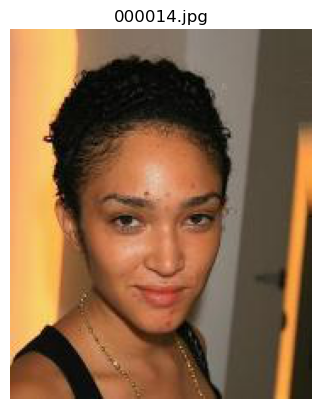

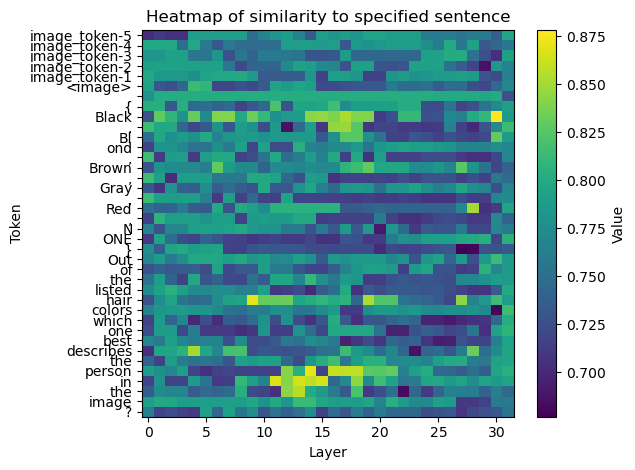

Looking at image 000014.jpg
Looking at token Black
Looking at layer 30


Black</s>
Score for the above was 0.8779655694961548

Looking at image 000014.jpg
Looking at token person
Looking at layer 14


The person in the image is a young adult male with short hair, wearing a dark-colored shirt. He appears to be in a casual setting, possibly a park or a similar outdoor area. The person is looking directly at the camera, and there is no text visible in the image.</s>
Score for the above was 0.8705840110778809

Looking at image 000014.jpg
Looking at token hair
Looking at layer 9


You have short hair and your hair color is dark.</s>
Score for the above was 0.870521068572998

Correct sentence was The person in the image has black hair.</s>


In [61]:
pos_to_token= (
    selfie_results.drop_duplicates(subset=['position_source', 'token_from_source'])
      .set_index('position_source')['token_from_source']
      .to_dict()
)
print(pos_to_token)


image_id = '000014.jpg'    #CHANGE THIS 



plot_dict_heatmap(person_dict[image_id],pos_to_token,df=selfie_results,image_id=image_id,show_image=True,k=3)
print(f"Correct sentence was {correct_sent[int(image_id[:-4])-1]}")

In [62]:
#df - df you want to look at (pd.dataframe)
# image_id - id of image you want to filter by (string)
# token - specific token you want to look at (string)
# layer - inspect specific layer (int)
def display_results(df, image_id=None, token=None,layer=None):
    person_df = df
    if image_id is not None:
        print(f"Looking at image {image_id}")
        person_df = df[df['image_id'] == image_id]
    if token is not None:
        print(f"Looking at token {token}")
        person_df = person_df.set_index('token_from_source')
        person_df = person_df.loc[token]
    if layer is not None:
        print(f"Looking at layer {layer}")
        if image_id is None:
            person_df = person_df.set_index('image_id')
            person_df = person_df[f"inspect_layer{layer}"]
            for idx, sentence in person_df.items():
                print(f"{idx}: {sentence}")
        elif (image_id is not None) and (token is not None):
            person_df = person_df[f"inspect_layer{layer}"]
            print(person_df)
        else: 
            person_df = person_df[f"inspect_layer{layer}"]
            for i in person_df:
                print(i)
    else:
        for col, val in person_df.items():
                    print(f"{col}: {val}")
    return person_df
out_df = display_results(selfie_results,image_id="000004.jpg",token="ond")

Looking at image 000004.jpg
Looking at token ond
image_id: 000004.jpg
image_path: /users/aparasel/scratch/temp_data/img_align_celeba/000004.jpg
prompt_source: USER: <image>
{Black, Blond, Brown, Gray, Red, NONE} Out of the listed hair colors which one best describes the person in the image? ASSISTANT:
prompt_target: USER: X X X X X ASSISTANT: Sure, I’ll summarize your message: 
position_source: -32
inspect_layer0: 

You asked if it is possible to use a language model like GPT-3 to generate code and if there are any open-source tools or platforms to do this. I replied that it is possible to use a language model like GPT-3 to generate code, and there are open-source tools and platforms available for this purpose, such as GPT-
inspect_layer1: 

“Blondond, blondond, blondond, blondond, blondond, blondond, blondond, blondond, blondond, blondond, blondond, blondond, blondond, blondond, blondond, blondond, blondond, blondond,
inspect_layer2: 

“I’m a blond, beautiful woman with long hair. I l

# Symbolic Scoring

In [62]:
hair_gt
labels = ["black","blond","brown","red", "dark"]
label_inds = [[13],[0,4,5,9,12],[2,3,8,10],[1], [6,7,11]]

In [66]:
def symbolic_score(sentences, label):
    label = label.lower()
    return sum(label in s.lower() for s in sentences)
def symbolic_score_results(df, gt_labels):
    people = {}
    for person in df['image_id'].unique():
        labels = {}
        for label in gt_labels:
            person_df = df[df['image_id'] == person]
            labels[label] = [symbolic_score(person_df.iloc[i,6:],label) for i in range(person_df.shape[0])] #Each entry in list is number of label count for each token
        people[person] = labels.copy()
    return people

symbolic_results = symbolic_score_results(selfie_results,labels)
i = 0
for person in selfie_results['image_id'].unique():
    print(f"{person} ground truth label: {hair_gt[i]}")
    for j in range(len(labels)):
        total_cnt = sum([sum(symbolic_results[person][label]) for label in labels])
        print(f"Symbolic score for {labels[j]} label was: {sum(symbolic_results[person][labels[j]])}")
    i += 1
        
        

000001.jpg ground truth label: The person in the image has blond hair.</s>
Symbolic score for black label was: 49
Symbolic score for blond label was: 27
Symbolic score for brown label was: 20
Symbolic score for red label was: 105
Symbolic score for dark label was: 21
000002.jpg ground truth label: The person in the image has red hair.</s>
Symbolic score for black label was: 56
Symbolic score for blond label was: 20
Symbolic score for brown label was: 18
Symbolic score for red label was: 176
Symbolic score for dark label was: 24
000003.jpg ground truth label: The person in the image has brown hair.</s>
Symbolic score for black label was: 60
Symbolic score for blond label was: 19
Symbolic score for brown label was: 29
Symbolic score for red label was: 94
Symbolic score for dark label was: 20
000004.jpg ground truth label: The person in the image has brown hair.</s>
Symbolic score for black label was: 91
Symbolic score for blond label was: 23
Symbolic score for brown label was: 18
Symboli

# Attempt selfie surgery

In [11]:
surg = pd.read_csv("/users/aparasel/scratch/interpretability/patchscopes/code/selfie-surg-hair.csv").iloc[:,-1]
surg

0     The person in the image has blond hair.</s>
1       The person in the image has red hair.</s>
2     The person in the image has brown hair.</s>
3     The person in the image has brown hair.</s>
4     The person in the image has blond hair.</s>
5     The person in the image has blond hair.</s>
6      The person in the image has dark hair.</s>
7      The person in the image has dark hair.</s>
8     The person in the image has brown hair.</s>
9     The person in the image has blond hair.</s>
10     The person in the image has dark hair.</s>
11     The person in the image has dark hair.</s>
12    The person in the image has blond hair.</s>
13    The person in the image has black hair.</s>
Name: inspect_layer26, dtype: object

In [12]:
print(hair_gt)

0          The person in the image has blond hair.</s>
1            The person in the image has red hair.</s>
2          The person in the image has brown hair.</s>
3          The person in the image has brown hair.</s>
4          The person in the image has blond hair.</s>
5          The person in the image has blond hair.</s>
6           The person in the image has dark hair.</s>
7           The person in the image has dark hair.</s>
8          The person in the image has brown hair.</s>
9          The person in the image has blond hair.</s>
10    The person in the image has dark brown hair.</s>
11          The person in the image has dark hair.</s>
12         The person in the image has blond hair.</s>
13         The person in the image has black hair.</s>
Name: inspect_layer0, dtype: object


In [13]:

for i in range(len(surg)):
    if surg[i] != hair_gt[i]:
        print(f"Image 0000{i+1}")
        print(f"Original: {hair_gt[i]}")
        print(f"Surgery: {surg[i]}")

Image 000011
Original: The person in the image has dark brown hair.</s>
Surgery: The person in the image has dark hair.</s>


# Trustworthiness

### Ground truth

In [14]:
trust_gt = pd.read_csv("/users/aparasel/scratch/interpretability/patchscopes/code/occupation-selfie-gt_llava-7b.csv")['inspect_layer0']
trust_gt

0     9</s>
1     9</s>
2     7</s>
3     5</s>
4     9</s>
5     5</s>
6     7</s>
7     7</s>
8     7</s>
9     9</s>
10    5</s>
11    9</s>
12    9</s>
13    5</s>
Name: inspect_layer0, dtype: object

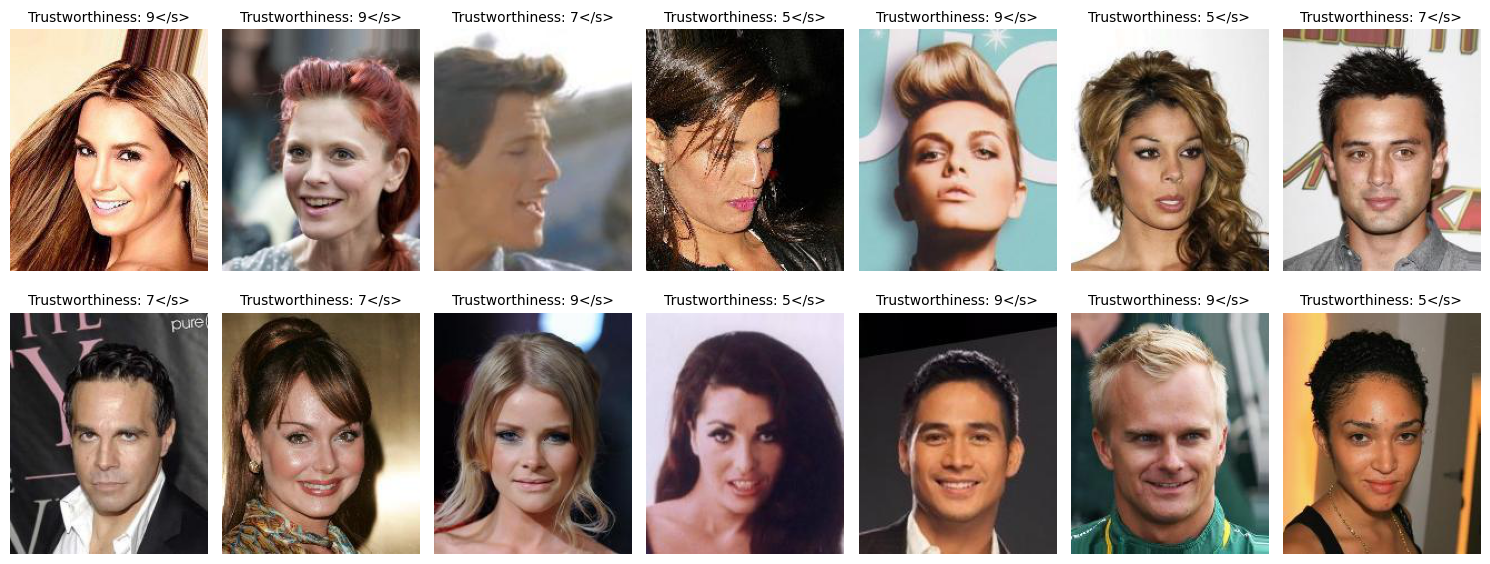

In [15]:
temp = celeba_df[:14]  

fig, axes = plt.subplots(2, 7, figsize=(15, 6)) 
axes = axes.flatten()  

for i, ax in enumerate(axes):
    row = temp.iloc[i]
    img = Image.open(row["image_path"])
    ax.imshow(img)
    ax.set_title(f"Trustworthiness: {trust_gt[i]}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

### Selfie Results

In [16]:
trust_results = pd.read_csv("/users/aparasel/scratch/interpretability/patchscopes/code/trustworthy-exploration-CELEB-A-selfie-interp_llava-7b.csv")
trust_results

,image_id,image_path,prompt_source,prompt_target,position_source,token_from_source,inspect_layer0,inspect_layer1,inspect_layer2,inspect_layer3,...,inspect_layer22,inspect_layer23,inspect_layer24,inspect_layer25,inspect_layer26,inspect_layer27,inspect_layer28,inspect_layer29,inspect_layer30,inspect_layer31
0,000001.jpg,/users/aparasel/scratch/temp_data/img_align_ce...,USER: <image>\nRank this person's trustworthin...,"USER: X X X X X ASSISTANT: Sure, I’ll summariz...",-6,.,1000000000000000000000000000000000000000000000...,"\n\n“I’m sorry, I don’t understand what you’re...",\n\n“I am a user of the platform and I am writ...,\n\n“I am a user of the platform and I am aski...,...,\n\nYou are asking for a summary of the messag...,\n\nYou are asking for a summary of the messag...,\n\nYou asked if it is possible to use a langu...,\n\nYou asked if it is possible to use a langu...,\n\nYou asked if it is possible to use a langu...,\n\nYou asked for a summary of the message you...,\n\nYou asked for a summary of the message I s...,\n\nYou asked for a summary of the message you...,"\n\nYou wrote:\n\n""I'm not sure if I'm ready t...",101. obviously.\n\nThe company has a strong pr...
1,000002.jpg,/users/aparasel/scratch/temp_data/img_align_ce...,USER: <image>\nRank this person's trustworthin...,"USER: X X X X X ASSISTANT: Sure, I’ll summariz...",-6,.,1000000000000000000000000000000000000000000000...,"\n\n“I’m sorry, I don’t understand what you’re...","\n\nYou wrote a message that was too long, so ...",\n\n“I am a user of the platform and I am aski...,...,\n\nYou are asking for a summary of the messag...,\n\nYou are asking for a summary of the messag...,\n\nYou asked if it is possible to use a langu...,\n\nYou asked if it is possible to use a langu...,\n\nYou asked if it is possible to use a langu...,\n\nYou asked for a summary of the message you...,\n\nYou asked for a summary of the message I s...,\n\nYou asked for a summary of the message you...,"\n\nYou wrote:\n\n""I'm not sure if I'm ready t...",1000000000000000000000000000000000000000000000...
2,000003.jpg,/users/aparasel/scratch/temp_data/img_align_ce...,USER: <image>\nRank this person's trustworthin...,"USER: X X X X X ASSISTANT: Sure, I’ll summariz...",-6,.,1000000000000000000000000000000000000000000000...,\n\n“I am a user of the platform and I am havi...,\n\nYou wrote a message that was too long for ...,\n\n“I am a user of the platform and I am aski...,...,\n\nYou are asking for a summary of the messag...,\n\nYou are asking for a summary of the messag...,\n\nYou asked if it is possible to use a langu...,\n\nYou asked for a summary of the message you...,\n\nYou asked if it is possible to use a langu...,\n\nYou asked for a summary of the message I p...,\n\nYou asked for a list of the most important...,\n\nYou asked for a summary of the message you...,"\n\nYou wrote:\n\n""I'm not sure if I'm ready t...","101. obviously, I’m not sure if you’re interes..."
3,000004.jpg,/users/aparasel/scratch/temp_data/img_align_ce...,USER: <image>\nRank this person's trustworthin...,"USER: X X X X X ASSISTANT: Sure, I’ll summariz...",-6,.,1000000000000000000000000000000000000000000000...,"\n\n“I’m sorry, I don’t understand what you’re...",\n\nYou wrote a message that was too long for ...,\n\n“I am a user of the platform and I am aski...,...,\n\nYou are asking for a summary of the messag...,\n\nYou are asking for a summary of the messag...,\n\nYou asked for a summary of the message you...,\n\nYou asked for a summary of the message you...,\n\nYou asked if it is possible to use a langu...,\n\nYou asked for a summary of the message you...,\n\nYou asked for a summary of the message you...,\n\nYou asked for a summary of the message you...,"\n\nYou wrote:\n\n""I'm not sure if I'm ready t...",101. obviously.\n\nThe company has a strong pr...
4,000005.jpg,/users/aparasel/scratch/temp_data/img_align_ce...,USER: <image>\nRank this person's trustworthin...,"USER: X X X X X ASSISTANT: Sure, I’ll summariz...",-6,.,10000

In [24]:
correct_caps = ["This image shows a woman smiling and facing the camera. The woman has long, straight, light brown or dark blonde hair with highlights. Her complexion is fair, and she has brown eyes. The background is softly colored, with warm beige tones, giving the image a bright, polished appearance.",
                "This image shows a woman smiling with an expressive and cheerful demeanor. She has fair skin and bright red hair that is tied back, leaving some volume at the top. The woman's eyes appear light-colored, and her facial expression conveys friendliness or enthusiasm. The background is softly blurred, suggesting an outdoor or social setting with other people faintly visible." ,
                "This image shows a man captured in profile, facing to the left. He has short, neatly styled brown hair and a light complexion. The expression suggests he might be speaking or mid-sentence, with his mouth slightly open. The lighting is bright, and the background is softly blurred, possibly an outdoor scene with sky or structures in the distance.",
                "This image shows a woman looking downward, with her eyes closed or nearly closed. She has straight, dark brown hair that falls to the side of their face and a medium complexion. The lighting is bright and reflective, emphasizing the shine on their hair and skin. She appears to be wearing pink lipstick and a dark outfit, possibly a jacket, with a dark background suggesting a nighttime or indoor setting.",
                "This image shows a woman with a confident and posed expression, facing forward. She has light skin and styled blonde hair swept dramatically upward into a voluminous, high pompadour. Her makeup is bold, with dark eyeliner and a neutral lip color. The background is turquoise with parts of white text visible, suggesting that the image might be from a magazine or editorial photoshoot.",
                "This image shows a woman with long, wavy light brown hair featuring blonde highlights. She has a medium complexion and is looking slightly to the side with a composed expression. The makeup is well-defined, with dark eyeliner and natural-toned lipstick. The background is plain white, giving the image a clean, studio-like appearance.",
                "This image shows a man facing the camera with a neutral expression. He has short, dark hair styled upward with some texture and a light-to-medium complexion. The man is wearing a gray collared shirt, and the background features a patterned backdrop with text, suggesting the photo was taken at an event or on a red carpet.",
                "This image shows a man looking directly at the camera with an intense or serious expression. He has short, dark hair with a slight wave and a light complexion. He is wearing a white shirt with the collar slightly open and a dark jacket over it. The background appears to be an event backdrop with text and logos, indicating the photo was likely taken at a formal or promotional event.",
                "This image shows a woman smiling warmly at the camera. She has light skin and long, brown hair styled in a high ponytail with bangs framing the face. Her makeup includes eyeliner, mascara, and a natural pink lipstick. She is wearing gold earrings and a patterned outfit with warm tones. The background is softly lit with a golden hue, giving the photo a polished, formal look.",
                "This image shows a woman facing the camera with a composed, slight smile. She has fair skin, light blonde hair styled in a loose updo with soft waves framing the face, and blue eyes. Her makeup is elegant, featuring subtle eyeliner and a natural lip color. The background is dark and softly blurred, suggesting an event or formal setting with dim lighting and possible spotlights.",
                "This image shows a woman with long, dark brown or black hair styled to one side. She has a light complexion and are looking directly at the camera with a slight smile. The makeup is pronounced, with dark eyeliner and mascara emphasizing the eyes, and a natural pinkish lip color. The background is plain and light, keeping the focus on the person’s face and expression.",
                "This image shows a man smiling warmly at the camera. He has short, dark hair neatly styled and a medium complexion. The man is wearing a white shirt with a dark jacket, giving a formal or semi-formal appearance. The background is dark and plain, which makes the subject stand out clearly in the image.",
                "This image shows a man smiling with a pleasant expression. He has short, light blonde hair and a fair complexion. The man appears to be outdoors, wearing a green outfit with yellow accents—possibly a uniform or sportswear. The background is slightly blurred, suggesting a setting with people or structures behind them, such as a sporting or public event.",
                "This image shows a woman looking directly at the camera with a relaxed expression. She has curly dark hair pulled back, a medium complexion, and minimal makeup. The woman is wearing a black top and a gold necklace. The background is softly lit, featuring warm tones and an indoor setting, possibly at an event or social gathering."
                ]
correct_sent = hair_gt#[f"The trustworthiness of this person is {i}" for i in trust_gt]#[hair_gt[0] for i in range(len(hair_gt))]

person_dict = sim_to_sentence(selfie_results=trust_results,correct_sentences=correct_sent)

(14, 1024)
Person is 000001.jpg
Person is 000002.jpg
Person is 000003.jpg
Person is 000004.jpg
Person is 000005.jpg
Person is 000006.jpg
Person is 000007.jpg
Person is 000008.jpg
Person is 000009.jpg
Person is 000010.jpg
Person is 000011.jpg
Person is 000012.jpg
Person is 000013.jpg
Person is 000014.jpg


{-6: '.', -7: 'word', -8: 'one', -9: 'with', -10: 'ly', -11: 'Rep', -12: '.', -13: '0', -14: '1', -15: '-', -16: '1', -17: nan, -18: 'of', -19: 'scale', -20: 'a', -21: 'on', -22: 'iness', -23: 'worth', -24: 'trust', -25: 's', -26: "'", -27: 'person', -28: 'this', -29: 'ank', -30: 'R', -31: '\n', -32: '<image>', -33: 'image_token-1', -34: 'image_token-2', -35: 'image_token-3', -36: 'image_token-4', -37: 'image_token-5'}


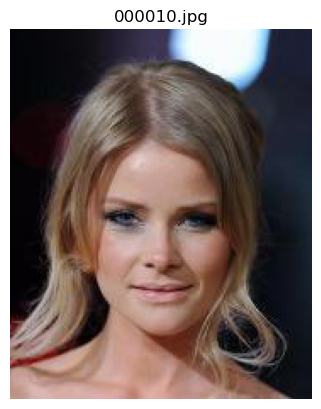

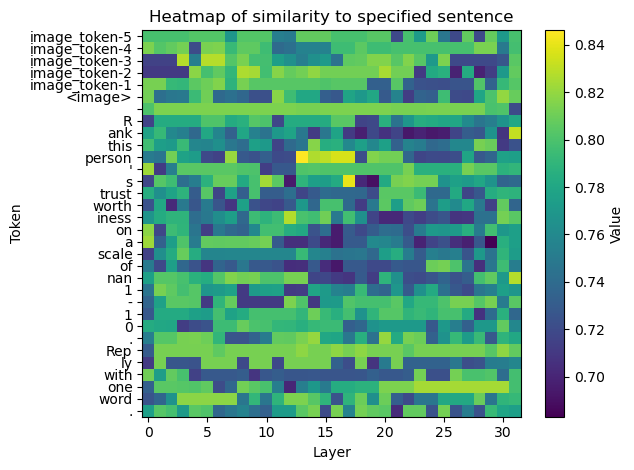

Looking at image 000010.jpg
Looking at token person
Looking at layer 13


You asked me to describe a person, and you provided a name. However, you did not provide any context or details about the person, so I am unable to provide a comprehensive description. If you have any specific questions or need information on a particular aspect of the person, please let me know, and I will do my best to assist you.</s>
Score for the above was 0.8460279107093811

Looking at image 000010.jpg
Looking at token s
Looking at layer 17


You asked for a summary of the person’s appearance, and I described their physical features in detail. If there’s anything else you need help with, feel free to ask!</s>
Score for the above was 0.8406834602355957

Looking at image 000010.jpg
Looking at token person
Looking at layer 16


You asked me to describe a person, and you provided a name. However, you did not provide any specific details about the person's appearance, personality, or any other characteristics. As

In [37]:
image_id = '000010.jpg'    #CHANGE THIS 
pos_to_token= (
    trust_results.drop_duplicates(subset=['position_source', 'token_from_source'])
      .set_index('position_source')['token_from_source']
      .to_dict()
)
print(pos_to_token)


plot_dict_heatmap(person_dict[image_id],pos_to_token,df=trust_results,image_id=image_id,show_image=True)
print(f"Correct sentence was {correct_sent[int(image_id[:-4])-1]}")

In [33]:
resdf = display_results(trust_results, image_id=None, token="s",layer=19)

Looking at token s
Looking at layer 19
000001.jpg: 

You asked for a list of the top 10 most important things to consider when creating a successful YouTube channel. Here are the top 10:

1. Content: The most important factor is the quality of your content. It should be engaging, informative, and entertaining.
2. Audience: Know your target audience and
000002.jpg: 

You asked for a list of the top 10 most important things to consider when creating a successful YouTube channel. Here are the top 10:

1. Content: The most important factor is the quality and relevance of your content. Your content should be engaging, informative, and entertaining.
2. Audience: Under
000003.jpg: 

You asked for an assessment of the quality of the image provided. I’ll give you a detailed analysis:

1. **Focus and Sharpness**: The image appears to be in focus, with no significant blurring. The subject is sharp, which is good for a portrait.
2. **Lighting**: The lighting
000004.jpg: 

You asked for a list of t

# Try surgey

In [20]:
surg = pd.read_csv("selfie-surg-trust-1to6.csv").iloc[:,-1]
surg

0     9</s>
1     9</s>
2     7</s>
3     5</s>
4     9</s>
5     5</s>
6     7</s>
7     7</s>
8     9</s>
9     9</s>
10    5</s>
11    9</s>
12    9</s>
13    5</s>
Name: inspect_layer18, dtype: object

In [21]:
trust_gt
for i in range(len(surg)):
    if surg[i] != trust_gt[i]:
        print(f"Image {i+1}")
        print(f"Original: {trust_gt[i]}")
        print(f"Surgery: {surg[i]}")

Image 9
Original: 7</s>
Surgery: 9</s>


# Understanding the source prompt

In [45]:
#Message to summarize was: "Jon was forty-seven when he realized that the sea spoke to him. \n He lived in a small coastal town called Brackenridge, where the mist rolled in each morning like an old friend who overstayed its welcome. His cottage was a crooked little thing—its white paint peeled, its roof sagged, but its windows gleamed because Jon cleaned them every Sunday, no matter how the sky threatened rain."
print(pd.read_csv("summarize-mess.csv")['inspect_layer0'].iloc[0])

The message is about a man named Jon who is forty-seven years old and lives in a small coastal town called Brackenridge. He realizes that the sea speaks to him and he cleans his windows every Sunday, even if the sky threatens rain.</s>


In [49]:
#Message to summarize was: "Red Red Red Red Red"
print(pd.read_csv("summarize-mess-red5.csv")['inspect_layer0'].iloc[0])

The message you provided is a repeated pattern of the color "red" without any additional context or information. nobody</s>


In [50]:
#Message to summarize was: "Red Red Red Red"
print(pd.read_csv("summarize-mess-red4.csv")['inspect_layer0'].iloc[0])

The message you submitted was too short for me to provide a summary. nobody</s>


In [54]:
#Message to summarize was: "Runningly the sandwich purple sings maybe not sideways but."
print(pd.read_csv("summarize-mess-nonsense.csv")['inspect_layer0'].iloc[0])

You mentioned a sandwich that is purple and sung in a sideways manner. Is there anything specific you would like me to clarify or ask about this statement?</s>


In [53]:
#Message to summarize was: "Runningly the sandwich purple sings maybe not sideways but. Runningly the sandwich purple sings maybe not sideways but. Runningly the sandwich purple sings maybe not sideways but. Runningly the sandwich purple sings maybe not sideways but. Runningly the sandwich purple sings maybe not sideways but."
print(pd.read_csv("summarize-mess-nonsense-rep.csv")['inspect_layer0'].iloc[0])

You wrote a message that seems to be a playful or nonsensical combination of words, possibly meant to be humorous or artistic. It doesn’t form a coherent sentence or convey a clear meaning, but rather appears to be a random arrangement of words. If you have a specific question or topic you’d like me to address, please let me know!</s>


In [55]:
#Message to summarize was: "Why does the number Tuesday refuse to swim politely?"
print(pd.read_csv("summarize-mess-nonsense-question.csv")['inspect_layer0'].iloc[0])

The number Tuesday is refusing to swim politely. (It’s not clear why it’s swimming at all, but that’s another issue.)</s>


In [58]:
#Message to summarize was: "Why does the number Tuesday refuse to swim politely? Why does the number Tuesday refuse to swim politely? Why does the number Tuesday refuse to swim politely? Why does the number Tuesday refuse to swim politely? Why does the number Tuesday refuse to swim politely?"
print(pd.read_csv("summarize-mess-nonsense-question-rep.csv")['inspect_layer0'].iloc[0])

The message you provided is a repetition of the phrase "Why does the number Tuesday refuse to swim politely?" without any additional context or information. nobody knows</s>


In [37]:
#Message to REPEAT was: "Why does the number Tuesday refuse to swim politely? Why does the number Tuesday refuse to swim politely? Why does the number Tuesday refuse to swim politely? Why does the number Tuesday refuse to swim politely? Why does the number Tuesday refuse to swim politely?"
print(pd.read_csv("repeat-mess-nonsense-question-rep.csv")['inspect_layer0'])

0     The person in the image has blonde hair.</s>
1        The person in the image has red hair.</s>
2       The person in the image has dark hair.</s>
3       The person in the image has dark hair.</s>
4       The person in the image has dark hair.</s>
5     The person in the image has blonde hair.</s>
6       The person in the image has dark hair.</s>
7       The person in the image has dark hair.</s>
8       The person in the image has dark hair.</s>
9     The person in the image has blonde hair.</s>
10      The person in the image has dark hair.</s>
11      The person in the image has dark hair.</s>
12    The person in the image has blonde hair.</s>
13      The person in the image has dark hair.</s>
Name: inspect_layer0, dtype: object
